# Q&A against Tabular Data from a CSV file  (experimental)

To really have a Smart Search Engine or Virtual assistant that can answer any question about your corporate documents, this "engine" must understand tabular data, aka, sources with tables, rows and columns with numbers. 
This is a different problem that simply looking for the top most similar results.  The concept of indexing, bringing top results, embedding, doing a cosine semantic search and summarize an answer, doesn't really apply to this problem.
We are dealing now with sources with Tables in which each row and column are related to each other, and in order to answer a question, all of the data is needed, not just top results.

In this notebook, the goal is to show how to deal with this kind of use cases. To continue with our Covid-19 theme, we will be using an open dataset called ["Covid Tracking Project"](https://covidtracking.com/data/download). The COVID Tracking Project dataset is a  CSV file that provides the latest numbers on tests, confirmed cases, hospitalizations, and patient outcomes from every US state and territory (they stopped tracking on March 7 2021).

Imagine that many documents on a data lake are tabular data, or that your use case is to ask questions in natural language to a LLM model and this model needs to get the context from a CSV file or even a SQL Database in order to answer the question. A GPT Smart Search Engine, must understand how to deal with this sources, understand the data and answer acoordingly.

In [6]:
import os
import pandas as pd
from langchain.llms import AzureOpenAI
from langchain.chat_models import AzureChatOpenAI
from langchain.agents import create_pandas_dataframe_agent
from langchain.agents import create_csv_agent

from common.prompts import CSV_PROMPT_PREFIX, CSV_PROMPT_SUFFIX

from IPython.display import Markdown, HTML, display  

from dotenv import load_dotenv
load_dotenv()

def printmd(string):
    display(Markdown(string))

In [7]:
# Set the ENV variables that Langchain needs to connect to Azure OpenAI
os.environ["OPENAI_API_BASE"] = os.environ["AZURE_OPENAI_ENDPOINT"]
os.environ["OPENAI_API_KEY"] = os.environ["AZURE_OPENAI_API_KEY"]
os.environ["OPENAI_API_VERSION"] = os.environ["AZURE_OPENAI_API_VERSION"]
os.environ["OPENAI_API_TYPE"] = "azure"

## Download the dataset and load it into Pandas Dataframe

In [8]:
os.makedirs("data",exist_ok=True)

In [9]:
!wget https://covidtracking.com/data/download/all-states-history.csv -P ./data/

--2023-12-21 18:26:16--  https://covidtracking.com/data/download/all-states-history.csv
Resolving covidtracking.com (covidtracking.com)... 

188.114.96.0, 188.114.97.0, 2a06:98c1:3121::, ...
Connecting to covidtracking.com (covidtracking.com)|188.114.96.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘./data/all-states-history.csv’

all-states-history.     [ <=>                ]   2.61M  --.-KB/s    in 0.06s   

2023-12-21 18:26:16 (47.0 MB/s) - ‘./data/all-states-history.csv’ saved [2738601]



In [10]:
file_url = "./data/all-states-history.csv"
df = pd.read_csv(file_url).fillna(value = 0)
print("Rows and Columns:",df.shape)
df.head()

Rows and Columns: (20780, 41)


,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-03-07,AK,305.0,0.0,0,0.0,1293.0,1293.0,33.0,0,...,1731628.0,0,0.0,0.0,0.0,0.0,0.0,0,1731628.0,0
1,2021-03-07,AL,10148.0,7963.0,-1,2185.0,45976.0,45976.0,494.0,0,...,2323788.0,2347,0.0,0.0,119757.0,0.0,2323788.0,2347,0.0,0
2,2021-03-07,AR,5319.0,4308.0,22,1011.0,14926.0,14926.0,335.0,11,...,2736442.0,3380,0.0,0.0,0.0,481311.0,0.0,0,2736442.0,3380
3,2021-03-07,AS,0.0,0.0,0,0.0,0.0,0.0,0.0,0,...,2140.0,0,0.0,0.0,0.0,0.0,0.0,0,2140.0,0
4,2021-03-07,AZ,16328.0,14403.0,5,1925.0,57907.0,57907.0,963.0,44,...,7908105.0,45110,580569.0,0.0,444089.0,0.0,3842945.0,14856,7908105.0,45110


In [6]:
df.columns

Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease'

## Introducing: Agents

The implementation of Agents is inspired by two papers: the [MRKL Systems](https://arxiv.org/abs/2205.00445) paper (pronounced ‘miracle’ 😉) and the [ReAct](https://arxiv.org/abs/2210.03629) paper.

Agents are a way to leverage the ability of LLMs to understand and act on prompts. In essence, an Agent is an LLM that has been given a very clever initial prompt. The prompt tells the LLM to break down the process of answering a complex query into a sequence of steps that are resolved one at a time.

Agents become really cool when we combine them with ‘experts’, introduced in the MRKL paper. Simple example: an Agent might not have the inherent capability to reliably perform mathematical calculations by itself. However, we can introduce an expert - in this case a calculator, an expert at mathematical calculations. Now, when we need to perform a calculation, the Agent can call in the expert rather than trying to predict the result itself. This is actually the concept behind [ChatGPT Plugins](https://openai.com/blog/chatgpt-plugins).

In our case, in order to solve the problem "How do I ask questions to a tabular CSV file", we need this REACT/MRKL approach, in which we need to instruct the LLM that it needs to use an 'expert/tool' in order to read/load/understand/interact with a CSV tabular file.

OpenAI opened the world to a whole new concept. Libraries are being created fast and furious. We will be using [LangChain](https://docs.langchain.com/docs/) as our library to solve this problem, however there are others that we recommend: [HayStack](https://haystack.deepset.ai/) and [Semantic Kernel](https://learn.microsoft.com/en-us/semantic-kernel/whatissk).

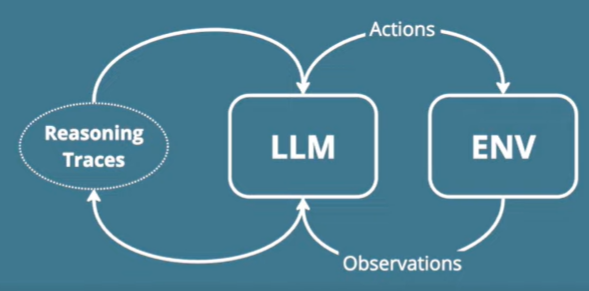

In [7]:
# Let's delve into a challenging question that demands a multi-step solution. The path to solving it might not be immediately clear.
# When examining the dataframe above, even a human might struggle to determine which columns are pertinent.

QUESTION = "How many patients were hospitalized during July 2020 in Texas, and nationwide as the total of all states? Use the hospitalizedIncrease column"

In [8]:
# First we load our LLM: GPT-4 (you are welcome to try GPT-3.5-Turbo. You will see that GPT-3.5 
# does not have the cognitive capabilities to solve a complex question and will make mistakes)
llm = AzureChatOpenAI(deployment_name="gpt-4", temperature=0, max_tokens=500)

Now we need our agent and our expert/tool.  
LangChain has created an out-of-the-box agents that we can use to solve our Q&A to CSV tabular data file problem. For more informatio about tje **CSV Agent** click [HERE](https://python.langchain.com/en/latest/modules/agents/toolkits/examples/csv.html)

In [9]:
agent_executor = create_pandas_dataframe_agent(llm=llm, df=df,verbose=True)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/langchain/agents/agent_toolkits/pandas/base.py:289: LangChainPendingDeprecationWarning: On 2023-10-27 this module will be be deprecated from langchain, and will be available from the langchain-experimental package.This code is already available in langchain-experimental.See https://github.com/langchain-ai/langchain/discussions/11680.
  warn_deprecated(


In [10]:
agent_executor.agent.allowed_tools

['python_repl_ast']

In [11]:
printmd(agent_executor.agent.llm_chain.prompt.template)


You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
You should use the tools below to answer the question posed of you:

python_repl_ast: A Python shell. Use this to execute python commands. Input should be a valid python command. When using this tool, sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [python_repl_ast]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question


This is the result of `print(df.head())`:
{df_head}

Begin!
Question: {input}
{agent_scratchpad}

## Enjoy the response and the power of GPT-4 + REACT/MKRL approach

In [14]:
# We are doing a for loop to retry N times. This is because: 
# 1) GPT-4 is still in preview and the API is being very throttled and 
# 2) Because the LLM not always gives the answer on the exact format the agent needs and hence cannot be parsed

for i in range(5):
    try:
        response = agent_executor.run(CSV_PROMPT_PREFIX + QUESTION + CSV_PROMPT_SUFFIX) 
        break
    except:
        response = "Error too many failed retries"
        continue
        
print(response)



> Entering new AgentExecutor chain...
Thought: To answer this question, I need to filter the dataframe for the month of July 2020 and then sum the 'hospitalizedIncrease' column for the state of Texas and for all states. But first, I need to set the pandas display options to show all the columns and get the column names.
Action: python_repl_ast
Action Input: 
```python
import pandas as pd

# Set pandas display options
pd.set_option('display.max_columns', None)

# Print column names
print(df.columns)
```
Observation: Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positi

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/langchain/tools/python/tool.py:137: LangChainPendingDeprecationWarning: On 2023-10-27 this module will be be deprecated from langchain, and will be available from the langchain-experimental package.This code is already available in langchain-experimental.See https://github.com/langchain-ai/langchain/discussions/11680.
  warn_deprecated(


The 'hospitalizedIncrease' column is present in the dataframe. Now, I need to filter the dataframe for the month of July 2020 and then sum the 'hospitalizedIncrease' column for the state of Texas and for all states.
Action: python_repl_ast
Action Input: 
```python
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Filter for July 2020
df_july_2020 = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2020-07-31')]

# Sum 'hospitalizedIncrease' for Texas
tx_hospitalized = df_july_2020[df_july_2020['state'] == 'TX']['hospitalizedIncrease'].sum()

# Sum 'hospitalizedIncrease' for all states
total_hospitalized = df_july_2020['hospitalizedIncrease'].sum()

tx_hospitalized, total_hospitalized
```
Observation: (0, 63105)
Thought:

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/langchain/tools/python/tool.py:137: LangChainPendingDeprecationWarning: On 2023-10-27 this module will be be deprecated from langchain, and will be available from the langchain-experimental package.This code is already available in langchain-experimental.See https://github.com/langchain-ai/langchain/discussions/11680.
  warn_deprecated(


The number of patients hospitalized in Texas during July 2020 is 0 and the total number of patients hospitalized in all states during July 2020 is 63105. However, to ensure the accuracy of this result, I will try another method to calculate these numbers.
Action: python_repl_ast
Action Input: 
```python
# Group by 'state' and sum 'hospitalizedIncrease'
grouped = df_july_2020.groupby('state')['hospitalizedIncrease'].sum()

# Get the number of hospitalized patients for Texas and for all states
tx_hospitalized_2 = grouped['TX']
total_hospitalized_2 = grouped.sum()

tx_hospitalized_2, total_hospitalized_2
```
Observation: (0, 63105)
Thought:

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/langchain/tools/python/tool.py:137: LangChainPendingDeprecationWarning: On 2023-10-27 this module will be be deprecated from langchain, and will be available from the langchain-experimental package.This code is already available in langchain-experimental.See https://github.com/langchain-ai/langchain/discussions/11680.
  warn_deprecated(


The number of patients hospitalized in Texas during July 2020 is 0 and the total number of patients hospitalized in all states during July 2020 is 63105. This result is consistent with the previous method, so I am confident in its accuracy.
Final Answer: During July 2020, there were 0 patients hospitalized in Texas and a total of 63105 patients hospitalized nationwide in all states.

Explanation:
I used the 'hospitalizedIncrease' column to calculate the number of patients hospitalized. I first filtered the dataframe for the month of July 2020, then summed the 'hospitalizedIncrease' column for the state of Texas and for all states. I confirmed the accuracy of this result by grouping the dataframe by 'state' and summing the 'hospitalizedIncrease' column, then getting the sum for Texas and for all states. Both methods gave the same result.

> Finished chain.
During July 2020, there were 0 patients hospitalized in Texas and a total of 63105 patients hospitalized nationwide in all states.



Bad pipe message: %s [b",\xdd.\xeb\xc6%\x02\xbb\x0e\xfaJ\xb0\xb3v\xc4\xf6\x95\xf3\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00"]
Bad pipe message: %s [b'\xacK\x95\xc7\xad,v4\xafS=\xdd\xf3\xd2-\xbf2+\x00\x00\xf4\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00\xa7\x00m\x00:\x00\x89\xc02\xc0', b"*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\x00\x84\xc0/\xc0+\xc0'\xc0#\xc0\x13\xc0\t\x00\xa4\x00\xa2\x00\xa0\x00\x9e\x00g\x00@\x00?\x00>\x003"]


## Evaluation
Let's see if the answer is correct

In [13]:
#df['date'] = pd.to_datetime(df['date'])
july_2020 = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2020-07-31')]
texas_hospitalized_july_2020 = july_2020[july_2020['state'] == 'TX']['hospitalizedIncrease'].sum()
nationwide_hospitalized_july_2020 = july_2020['hospitalizedIncrease'].sum()

print("TX:",texas_hospitalized_july_2020,"Nationwide:",nationwide_hospitalized_july_2020)

TX: 0 Nationwide: 63105


It is Correct!

**Note**: Obviously, there were hospitalizations in Texas in July 2020 (Try asking ChatGPT), but this particular File, for some reason has 0 on the column "hospitalizedIncrease" for Texas in July 2020. This proves though that the model is NOT making up information or using prior knowledge, but instead using only the results of its calculation on this CSV file. That's what we need!

**Note 2**: You will also notice that if you run the above cell multiple times, not always you will get the same result. Sometimes it will even fail an error out. Why? 
1) This is still a very new field and LLMs and libraries still has a lot room to grow
2) Because for complex questions that require multiple steps to solve it, even humans make mistakes
3) Because if the column names are not clear, or ambiguous, or the data is not clean, it will make mistakes, just as humans would.

# Summary

So, we just solved our problem on how to ask questions in natural language to our Tabular data hosted on a CSV File.
With this approach you can see then that it is NOT necessary to make a dump of a database data into a CSV file and index that on a Search Engine, you don't even need to use the above approach and deal with a CSV data dump file. With the Agents framework, the best engineering decision is to interact directly with the data source API without the need to replicate the data in order to ask questions to it. Remember, GPT-4 can do SQL very well. 

Just think about this: if GPT-4 can do the above, imagine what GPT-5/6/7/8 will be able to do.

**Note**: We don't recommend using a pandas agent to answer questions from tabular data. It is not fast and it makes too many parsing mistakes. We recommend using SQL (see next notebook).

# Reference

- https://haystack.deepset.ai/blog/introducing-haystack-agents
- https://python.langchain.com/en/latest/modules/agents/agents.html
- https://tsmatz.wordpress.com/2023/03/07/react-with-openai-gpt-and-langchain/
- https://medium.com/@meghanheintz/intro-to-langchain-llm-templates-and-agents-8793f30f1837

# NEXT
We can see that GPT-4 is powerful and can translate a natural language question into the right steps in python in order to query a CSV data loaded into a pandas dataframe. 
That's pretty amazing. However the question remains: **Do I need then to dump all the data from my original sources (Databases, ERP Systems, CRM Systems) in order to be searchable by a Smart Search Engine?**

The next Notebook answers this question by implementing a Question->SQL process and get the information from data in a SQL Database, eliminating the need to dump it out.